# Experimental analysis PUFFINN

In [657]:
import pandas as pd
from IPython.display import display
%matplotlib inline
import matplotlib
matplotlib.use('pgf')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] =(12,9)
pd.options.display.max_rows = 2000
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'cmu serif'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

rename_d = {
    'filter=filter)' : 'filter',
    'filter=simple)' : 'simple',
    'filter=none)' : 'no filter'
}

def pgfplot(df, xaxis, yaxis, splitting, title, filter_plot={}, scale = lambda x: 1, xtitle="", ytitle=""):
        print("""\\begin{tikzpicture}[every mark/.append style={mark size=1.5pt}]
            \\begin{axis}[
                title = {%s},
                xlabel = {%s},
                ylabel = {%s},
                width = \\textwidth,
                height = 6cm,
                ymode=log,
                legend style = {opacity = 0.6, text opacity = 1},
                grid = both, grid style={line width=.1pt, draw=gray!30},
major grid style={line width=.2pt,draw=gray!50},
            ]
            """ % (title, xtitle.replace("_", "\_"), ytitle.replace("_", "\_")))
        algos = set(df[splitting])
        #print(algos)
        for algo in algos:
            # skip filtered algorithms
            if algo in filter_plot and ds in filter_plot[algo]:
                continue
            #print(df[df[splitting] == algo])
            val = [(x,y) for x,y in df[df[splitting] == algo][[xaxis,yaxis]].sort_values(xaxis).itertuples(index=False)]
            print("\\addplot coordinates {", end=' ')
            for x, y in val:
                print("(%f, %f)" % (float(x), float(y) / scale(float(x))), end=' ')
            #p([int(x) for (x,_) in val], [int(y) / scale(x)  for (x, y) in val], label=algo)
            print("};")
            print("\\addlegendentry{%s};" % algo.replace("_", "\_"))
        #plt.title(title + " on " + ds)  
        print("\\end{axis}\\end{tikzpicture}")
            

def get_pareto_frontier(df, x, y, split):
    # removes all rows that don't lie on the pareto frontier
    to_plot = df.sort_values(y,ascending=False).reset_index(drop=True)
    d = {} # store last x values
    drop_list = []
    for algo in set(df[split]):
        d[algo] = 0
    for i in range(len(to_plot)):
        x_ = to_plot.iloc[i][x]
        y_ = to_plot.iloc[i][y]
        algo = to_plot.iloc[i][split]
        if x_ > d[algo]:
            d[algo] = x_
        else:
            drop_list.append(i)
    to_plot.drop(drop_list, inplace=True)
        
    return to_plot

In [705]:
data = pd.read_csv("all.csv")
data.head()

,algorithm,build,candidates,count,dataset,distcomps,epsilon,indexsize,k-nn,k-nn-median,k-nn-perc-25,k-nn-perc-5,k-nn-perc-75,k-nn-perc-95,k-nn-std,largeepsilon,parameters,qps,qps-median,qps-perc-25,qps-perc-5,qps-perc-75,qps-perc-95,queriessize,rel
0,hnsw(faiss),229.697639,1.0,1,difficult-annoy-angular,6097.434,0.0,1321080.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"faiss ({u'efConstruction': 500, u'M': 8})",347.496180,355.479614,346.150360,336.885184,357.784180,359.964294,3801.710860,1.743438
1,hnsw(faiss),7804.277806,1.0,1,difficult-annoy-angular,133525.730,0.0,2022492.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"faiss ({u'efConstruction': 500, u'M': 96})",19.497806,19.534058,19.435079,19.280876,19.590214,19.644090,103729.210553,1.688313
2,hnsw(faiss),747.532169,1.0,1,difficult-annoy-angular,18623.036,0.0,1445332.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"faiss ({u'efConstruction': 500, u'M': 24})",150.524667,151.091644,150.625015,143.841528,151.533798,152.255500,9601.961099,1.711060
3,hnsw(faiss),7804.277806,1.0,1,difficult-annoy-angular,37007.797,0.0,2022492.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"faiss ({u'efConstruction': 500, u'M': 96})",73.551996,73.841431,73.561050,71.770934,74.046745,74.289573,27497.445536,1.696033
4,hnsw(faiss),7804.277806,1.0,1,difficult-annoy-angular,7832.219,0.0,2022492.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"faiss ({u'efConstruction': 500, u'M': 96})",341.028051,352.225739,348.682678,317.311658,354.727997,358.181396,5930.573728,1.723421


In [621]:
set(data.algorithm)

{'MP-lsh(lshkit)',
 'NGT-onng',
 'annoy',
 'faiss-ivf',
 'falconn',
 'flann',
 'hnsw(faiss)',
 'puffinn',
 'puffinn-pool',
 'puffinn-python',
 'puffinn-python-cp',
 'puffinn-python-fhtcp',
 'puffinn-python-filter-variants',
 'puffinn-python-high-sketch-independent',
 'puffinn-python-independent',
 'puffinn-python-k18-independent',
 'puffinn-python-nosketch-independent',
 'puffinn-python-pool-fastrotations',
 'puffinn-python-pooling-strategy',
 'puffinn-python-simhash',
 'puffinn-python-sketch-independent',
 'puffinn-python-tensor',
 'puffinn-python-test'}

In [482]:
data[data.algorithm.str.contains('MP')]

,algorithm,build,candidates,count,dataset,distcomps,epsilon,indexsize,k-nn,k-nn-median,k-nn-perc-25,k-nn-perc-5,k-nn-perc-75,k-nn-perc-95,k-nn-std,largeepsilon,parameters,qps,qps-median,qps-perc-25,qps-perc-5,qps-perc-75,qps-perc-95,queriessize,rel
3816,MP-lsh(lshkit),153.853746,10.0,10,glove-100-angular,0.0,0.41041,2878320.0,0.36584,0.3,0.2,0.0,0.5,0.8,0.244293,0.81333,"Nmslib(method_name=lsh_multiprobe, index_param...",18.114496,17.958951,13.110826,9.877218,29.665625,109.984400,158895.946974,1.056897
3817,MP-lsh(lshkit),170.265430,10.0,10,glove-100-angular,0.0,0.33030,3070436.0,0.29785,0.3,0.1,0.0,0.5,0.8,0.246285,0.67078,"Nmslib(method_name=lsh_multiprobe, index_param...",79.978904,107.670494,55.333461,28.141182,259.713272,1400.435425,38390.573437,1.097699
3818,MP-lsh(lshkit),146.247967,10.0,10,glove-100-angular,0.0,0.42930,2791064.0,0.38085,0.4,0.2,0.0,0.5,0.8,0.242108,0.83156,"Nmslib(method_name=lsh_multiprobe, index_param...",9.632819,8.988443,7.815611,6.940772,11.590798,27.258396,289745.295914,1.051193
3819,MP-lsh(lshkit),165.713555,10.0,10,glove-100-angular,0.0,0.29332,3169604.0,0.26564,0.2,0.1,0.0,0.4,0.7,0.241631,0.59174,"Nmslib(method_name=lsh_multiprobe, index_param...",170.679702,256.015625,122.888399,54.601500,635.476578,2519.101562,18570.480038,1.124109
3820,MP-lsh(lshkit),166.944859,10.0,10,glove-100-angular,0.0,0.36549,3026612.0,0.32801,0.3,0.1,0.0,0.5,0.8,0.247371,0.73793,"Nmslib(method_name=lsh_multiprobe, index_param...",43.032033,51.642227,29.103567,17.093932,118.404566,699.289584,70333.930356,1.078004
3821,MP-lsh(lshkit),173.255606,10.0,10,glove-100-angular,0.0,0.14775,3451440.0,0.13529,0.1,0.0,0.0,0.2,0.6,0.193116,0.28676,"Nmslib(method_name=lsh_multiprobe, index_param...",1195.433852,2045.004395,1134.822754,372.992798,2824.447021,3279.362061,2887.186099,1.294487
3822,MP-lsh(lshkit),170.741335,10.0,10,glove-100-angular,0.0,0.38697,2929200.0,0.34634,0.3,0.1,0.0,0.5,0.8,0.246785,0.77765,"Nmslib(method_name=lsh_multiprobe, index_param...",28.987148,31.487114,20.072065,13.318164,61.696365,295.949803,101051.679517,1.066606
3823,MP-lsh(lshkit),163.889343,10.0,10,glove-100-angular,0.0,0.20280,3353744.0,0.18540,0.1,0.0,0.0,0.3,0.7,0.218808,0.39979,"Nmslib(method_name=lsh_multiprobe, index_param...",672.346506,1142.862183,550.578140,205.818102,2212.185547,3457.793945,4988.118435,1.213421
3824,MP-lsh(lshkit),144.435095,10.0,10,glove-100-angular,0.0,0.42329,2797356.0,0.37607,0.4,0.2,0.0,0.5,0.8,0.242199,0.82772,"Nmslib(method_name=lsh_multiprobe, index_param...",11.230033,10.630844,8.713477,7.364261,15.001356,39.806486,249095.971629,1.052790
3825,MP-lsh(lshkit),181.195814,10.0,10,glove-100-angular,0.0,0.25220,3266588.0,0.22942,0.2,0.0,0.0,0.4,0.7,0.233385,0.50597,"Nmslib(method_name=lsh_multiprobe, index_param...",310.745449,522.199219,235.238586,94.081927,1280.703918,3355.443115,10512.102452,1.159752


In [51]:
above09 = data[data['k-nn'] > 0.9]

In [52]:
for i in ['=filter', '=simple', '=none']:
    print(i)
    print(above09[above09.parameters.str.contains('32000') & above09.parameters.str.contains(i)][['qps','k-nn','parameters']])

=filter
             qps     k-nn                                         parameters
1037  169.109206  0.93084  PUFFINN(space=32000000000, recall=0.990000, sk...
=simple
             qps     k-nn                                         parameters
1002  218.524779  0.92420  PUFFINN(space=32000000000, recall=0.900000, sk...
1004  190.288104  0.93546  PUFFINN(space=32000000000, recall=0.950000, sk...
1024  144.036585  0.96076  PUFFINN(space=32000000000, recall=0.990000, sk...
=none
             qps     k-nn                                         parameters
977   140.608563  0.95708  PUFFINN(space=32000000000, recall=0.100000, sk...
978    87.368812  0.97722  PUFFINN(space=32000000000, recall=0.950000, sk...
979    60.401891  0.98655  PUFFINN(space=32000000000, recall=0.990000, sk...
1068  105.644029  0.97169  PUFFINN(space=32000000000, recall=0.900000, sk...
1090  140.128744  0.95766  PUFFINN(space=32000000000, recall=0.500000, sk...
1108  144.600349  0.95708  PUFFINN(space=32000000000, 

In [229]:
splitting = data['parameters'].str.split(" ", expand=True)

data['space'] = splitting[0]
data['recall'] = splitting[1]
data['sketch_eps'] = splitting[2]
data['filter'] = splitting[3]

# No filter against filter speedup

Fix two index sizes (512mb and 8gb and see how it turns out.)

In [600]:
space1 = "space=594967296"
space2 = "space=4594967296"

fd = data[data.algorithm.str.contains("filter")].reset_index()

splitting = fd['parameters'].str.split(" ", expand=True)

fd['space'] = splitting[0]
fd['recall'] = splitting[1]
fd['sketch_eps'] = splitting[2]
fd['filter'] = splitting[3]

#fd = fd[fd.space.str.contains(space1) & ~fd['filter'].str.contains("=filter")][['k-nn', 'filter','qps', 'recall', 'parameters']].sort_values('qps')

In [ ]:
#data[data.space.str.contains(space1) & ~data['filter'].str.contains("=filter")].sort_values(['filter', 'recall'])

<function matplotlib.pyplot.legend(*args, **kwargs)>

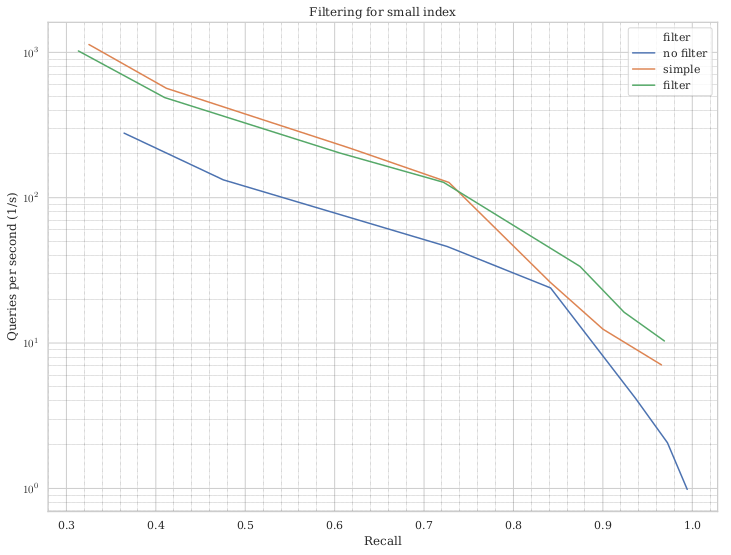

In [601]:
ax = sns.lineplot(x='k-nn', y='qps', hue='filter', data=fd[fd.space.str.contains(space1)].replace(rename_d))
ax.set_yscale('log')
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.1', alpha=.3, color='black')

plt.title("Filtering for small index")
plt.ylabel("Queries per second (1/s)")
plt.xlabel("Recall")

plt.legend

\begin{tikzpicture}[every mark/.append style={mark size=1.5pt}]
            \begin{axis}[
                title = {Sketching/no sketching},
                xlabel = {},
                ylabel = {},
                width = \textwidth,
                height = 6cm,
                ymode=log,
                legend style = {opacity = 0.6, text opacity = 1},
                grid = both, grid style={line width=.1pt, draw=gray!30},
major grid style={line width=.2pt,draw=gray!50},
            ]
            
\addplot coordinates { (0.322900, 2156.668901) (0.402860, 1693.227196) (0.659400, 793.008491) (0.764300, 534.466913) (0.876040, 346.633897) (0.918170, 255.000076) (0.964750, 139.198539) };
\addlegendentry{filter=filter)};
\addplot coordinates { (0.530490, 898.193404) (0.567850, 805.809243) (0.775120, 299.487249) (0.866350, 182.199221) (0.945830, 100.939947) (0.974600, 59.115333) (0.989220, 26.795525) };
\addlegendentry{filter=none)};
\addplot coordinates { (0.455340, 1851.714399) (0.496530

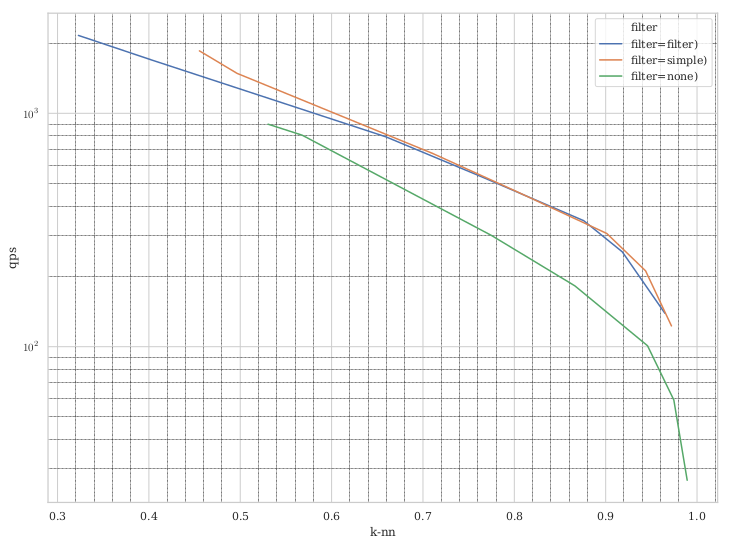

In [607]:
ax = sns.lineplot(x='k-nn', y='qps', hue='filter', data=fd[fd.space.str.contains("4294967296")])
ax.set_yscale('log')
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')

pgfplot(fd[fd.space.str.contains("4294967296")], 'k-nn', 'qps', 'filter', 'Sketching/no sketching')


# Influence of filter thresholds

Keep index size fixed, play around with filter thresholds. Only have data for 1gb index due to old problems with index size...

In [ ]:
eps_df = data[(data.algorithm == 'puffinn-python-sketch-independent') & (data.dataset == 'glove-100-angular')].reset_index()


In [290]:
splitting = eps_df['parameters'].str.split(" ", expand=True)

eps_df['space'] = splitting[0]
eps_df['recall'] = splitting[1]
eps_df['sketch_eps'] = splitting[2]

eps_df = eps_df[eps_df.space.str.contains("1294967296")]

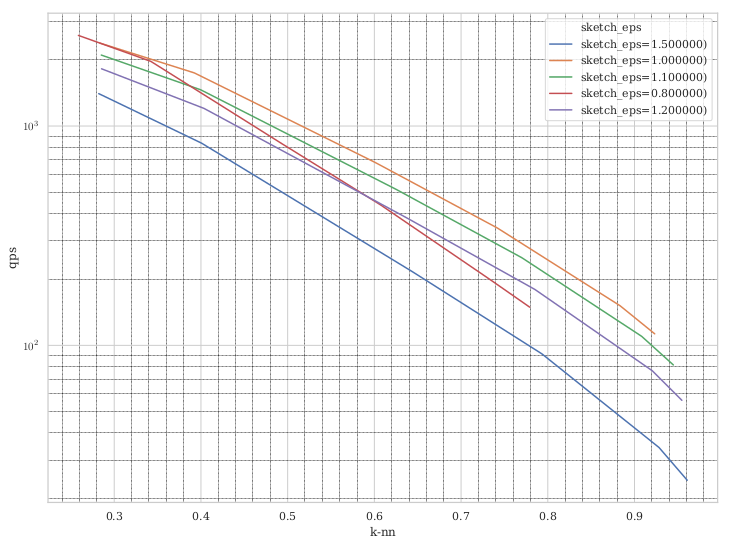

In [531]:
ax = sns.lineplot(x='k-nn', y='qps', hue='sketch_eps', data=eps_df)
ax.set_yscale('log')
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')



We see that setting it to the expectation is the best choice in this parameter landscape.

## Comparison between different pooling strategies

In [ ]:
# redo experiments since index size was probably too small.

In [554]:
df = data[data.algorithm.str.contains("pooling")].reset_index()


In [556]:
splitting = df['parameters'].str.split(" ", expand=True)

def pretty_print_parameters(df):
    for i in range(len(df.columns)):
        df[i] = df[i].map(lambda x: x.split('=')[1][:-1])
    return df

splitting = df['parameters'].str.split(" ", expand=True)
splitting = pretty_print_parameters(splitting)

df['space'] = splitting[0]
df['recall'] = splitting[1]
df['hash'] = splitting[4]
df['strategy'] = splitting[5]



In [557]:
df[df.hash == 'crosspolytope']

,index,algorithm,build,candidates,count,dataset,distcomps,epsilon,indexsize,k-nn,k-nn-median,k-nn-perc-25,k-nn-perc-5,k-nn-perc-75,k-nn-perc-95,k-nn-std,largeepsilon,parameters,qps,qps-median,qps-perc-25,qps-perc-5,qps-perc-75,qps-perc-95,queriessize,rel,space,recall,hash,strategy
1,3410,puffinn-python-pooling-strategy,152.019869,10.0,10,glove-100-angular,18195.4815,0.98299,3239328.0,0.93587,1.0,0.9,0.8,1.0,1.0,0.085921,0.99998,"PUFFINN(space=4294967296, recall=0.990000, ske...",154.649420,214.394356,113.422409,54.990281,406.051025,1245.081030,20946.266760,1.002123,4294967296,0.990000,crosspolytope,pool
4,3413,puffinn-python-pooling-strategy,425.503434,10.0,10,glove-100-angular,1271.9907,0.36077,11282600.0,0.31972,0.3,0.2,0.0,0.4,0.7,0.195062,0.82959,"PUFFINN(space=8594967296, recall=0.200000, ske...",879.438739,991.326843,799.371826,581.734253,1108.724243,1205.606201,12829.318860,1.085145,8594967296,0.200000,crosspolytope,tensor
5,3414,puffinn-python-pooling-strategy,160.126247,10.0,10,glove-100-angular,11757.0981,0.97697,12502844.0,0.92935,1.0,0.9,0.7,1.0,1.0,0.094718,0.99994,"PUFFINN(space=8594967296, recall=0.990000, ske...",206.093094,218.248726,144.573845,97.846756,418.875420,1158.983667,60666.001817,1.002342,8594967296,0.990000,crosspolytope,pool
6,3415,puffinn-python-pooling-strategy,152.019869,10.0,10,glove-100-angular,4045.8564,0.76126,3239328.0,0.66382,0.7,0.5,0.4,0.8,0.9,0.183366,0.99528,"PUFFINN(space=4294967296, recall=0.700000, ske...",612.577444,739.019287,436.123024,260.513351,1573.404907,2208.690918,5288.030161,1.020832,4294967296,0.700000,crosspolytope,pool
7,3416,puffinn-python-pooling-strategy,1730.050346,10.0,10,glove-100-angular,764.0838,0.39572,13091236.0,0.35467,0.3,0.2,0.1,0.5,0.8,0.224331,0.86334,"PUFFINN(space=8594967296, recall=0.200000, ske...",77.801166,80.555901,72.830105,68.057146,84.047455,87.063911,168265.293671,1.076605,8594967296,0.200000,crosspolytope,independent
15,3424,puffinn-python-pooling-strategy,107.175212,10.0,10,glove-100-angular,14343.8159,0.91697,1975412.0,0.82076,0.8,0.7,0.6,0.9,1.0,0.136092,0.99976,"PUFFINN(space=1294967296, recall=0.900000, ske...",163.728975,173.788734,116.230782,82.227066,308.870293,725.802539,12065.133838,1.008878,1294967296,0.900000,crosspolytope,independent
18,3427,puffinn-python-pooling-strategy,216.524476,10.0,10,glove-100-angular,4335.5597,0.78013,3501032.0,0.67987,0.7,0.6,0.4,0.8,1.0,0.178005,0.99752,"PUFFINN(space=2294967296, recall=0.700000, ske...",298.611408,316.014618,250.193352,186.261602,404.241035,524.288025,11724.374581,1.019111,2294967296,0.700000,crosspolytope,independent
19,3428,puffinn-python-pooling-strategy,205.665282,10.0,10,glove-100-angular,3172.3771,0.51450,2414012.0,0.44949,0.4,0.3,0.1,0.6,0.8,0.201419,0.96575,"PUFFINN(space=2294967296, recall=0.500000, ske...",877.637015,1000.430298,727.514664,372.320657,1493.033691,2628.010010,2750.581345,1.051915,2294967296,0.500000,crosspolytope,tensor
21,3430,puffinn-python-pooling-strategy,160.126247,10.0,10,glove-100-angular,2063.9931,0.64163,12502844.0,0.56254,0.6,0.4,0.2,0.7,0.9,0.204902,0.98364,"PUFFINN(space=8594967296, recall=0.500000, ske...",795.494024,1060.372681,608.178635,388.038116,1313.182251,1509.828613,15717.080991,1.032840,8594967296,0.500000,crosspolytope,pool
22,3431,puffinn-python-pooling-strategy,1730.050346,10.0,10,glove-100-angular,10002.3714,0.98563,13091236.0,0.94316,1.0,0.9,0.8,1.0,1.0,0.082748,0.99998,"PUFFINN(space=8594967296, recall=0.990000, ske...",63.281101,64.292835,57.749715,49.498839,71.739197,82.264082,206874.340117,1.001676,8594967296,0.990000,crosspolytope,independent


\begin{tikzpicture}[every mark/.append style={mark size=1.5pt}]
            \begin{axis}[
                title = {Tensor/Pool/Independent 8GB},
                xlabel = {},
                ylabel = {},
                width = \textwidth,
                height = 6cm,
                ymode=log,
                legend style = {opacity = 0.6, text opacity = 1},
                grid = both, grid style={line width=.1pt, draw=gray!30},
major grid style={line width=.2pt,draw=gray!50},
            ]
            
\addplot coordinates { (0.218860, 2439.874901) (0.310630, 937.482289) (0.539220, 293.450016) (0.687090, 166.103970) (0.869310, 36.824938) (0.918720, 22.182805) (0.965280, 11.125753) };
\addlegendentry{independent};
\addplot coordinates { (0.217050, 1627.530098) (0.309070, 637.729792) (0.539980, 207.844760) (0.694440, 118.066237) (0.871780, 30.319863) (0.920850, 18.030915) (0.968930, 9.099753) };
\addlegendentry{pool};
\addplot coordinates { (0.160860, 2269.313442) (0.217340, 622.02802

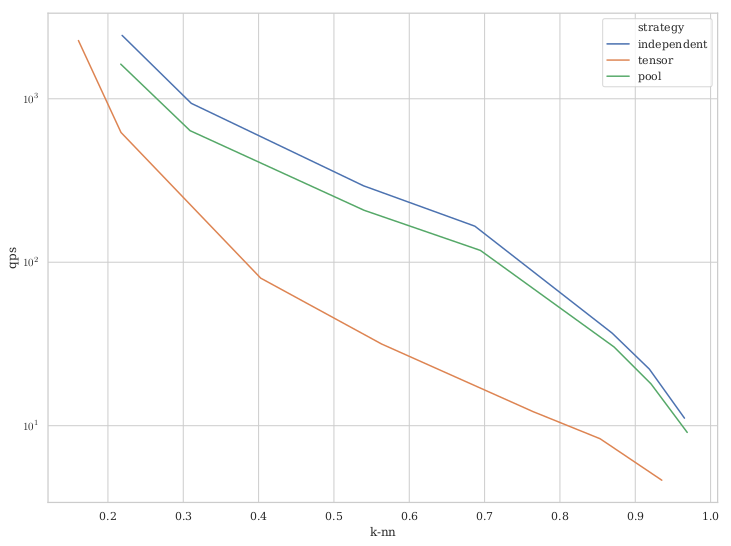

In [609]:
ax = sns.lineplot(x='k-nn', y='qps', hue='strategy', data=df[(df.space == '594967296') & (df.hash == 'fht_crosspolytope')])
pgfplot(df[(df.space == '594967296') & (df.hash == 'fht_crosspolytope')], 'k-nn', 'qps', 'strategy', 'Tensor/Pool/Independent 8GB')
ax.set_yscale('log')


## Comparison between different hash functions

In [ ]:
# experiments running on preciousss

In [567]:
df = data[data.algorithm.str.contains("pooling")].reset_index()

In [568]:
splitting = df['parameters'].str.split(" ", expand=True)

def pretty_print_parameters(df):
    for i in range(len(df.columns)):
        df[i] = df[i].map(lambda x: x.split('=')[1][:-1])
    return df

splitting = df['parameters'].str.split(" ", expand=True)
splitting = pretty_print_parameters(splitting)

df['space'] = splitting[0]
df['recall'] = splitting[1]
df['hash'] = splitting[4]
df['strategy'] = splitting[5]



\begin{tikzpicture}[every mark/.append style={mark size=1.5pt}]
            \begin{axis}[
                title = {FHT/CP/SH 4GB},
                xlabel = {},
                ylabel = {},
                width = \textwidth,
                height = 6cm,
                ymode=log,
                legend style = {opacity = 0.6, text opacity = 1},
                grid = both, grid style={line width=.1pt, draw=gray!30},
major grid style={line width=.2pt,draw=gray!50},
            ]
            
\addplot coordinates { (0.273560, 1468.699550) (0.347400, 1375.148287) (0.562540, 795.494024) (0.677580, 568.189443) (0.816330, 360.071882) (0.868080, 292.862714) (0.929350, 206.093094) };
\addlegendentry{crosspolytope};
\addplot coordinates { (0.397540, 809.749362) (0.520720, 610.272029) (0.744260, 339.160245) (0.851350, 115.608813) (0.946790, 136.064334) (0.969370, 104.488635) (0.988070, 63.224903) };
\addlegendentry{simhash};
\addplot coordinates { (0.302500, 1095.998051) (0.389860, 912.374386) 

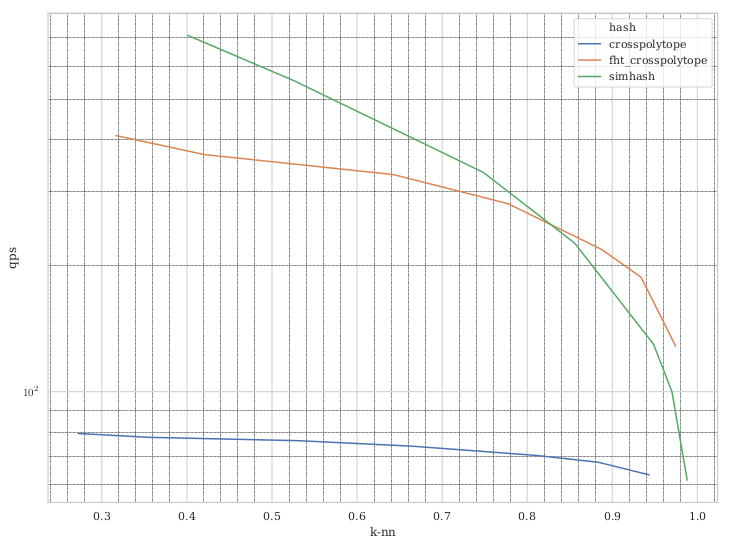

In [710]:
ax = sns.lineplot(x='k-nn', y='qps', hue='hash', data=df[(df.space == '8594967296') & (df.strategy == 'independent')])
ax.set_yscale('log')
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
pgfplot(df[(df.space == '8594967296') & (df.strategy == 'pool')], 'k-nn', 'qps','hash', 'FHT/CP/SH 4GB' )

## Comparison between certain algorithms

In [706]:
def plot_comparison(ds='glove-100-angular', algorithms=['BallTree(nmslib)', 'falconn', 'puffinn-python', 'annoy', 'faiss-ivf', 'flann', 'NGT-onng'], count=10):
    to_plot = data[(data.dataset == ds) & (data.algorithm.isin(algorithms)) & (data['count']== count)][['algorithm', 'k-nn', 'qps']]

    to_plot = get_pareto_frontier(to_plot, 'k-nn', 'qps', 'algorithm')

    ax = sns.lineplot(x='k-nn', y='qps', hue='algorithm', data=to_plot)
    ax.set_yscale('log')
    ax.set_title(ds)
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')

    pgfplot(to_plot, 'k-nn', 'qps', 'algorithm', 'Comparison on %s' % ds)


\begin{tikzpicture}[every mark/.append style={mark size=1.5pt}]
            \begin{axis}[
                title = {Comparison on glove-100-angular},
                xlabel = {},
                ylabel = {},
                width = \textwidth,
                height = 6cm,
                ymode=log,
                legend style = {opacity = 0.6, text opacity = 1},
                grid = both, grid style={line width=.1pt, draw=gray!30},
major grid style={line width=.2pt,draw=gray!50},
            ]
            
\addplot coordinates { (0.406390, 83.820759) (0.600470, 64.658111) (0.714960, 49.408357) (0.812810, 45.129181) (0.884680, 35.969848) (0.927640, 29.743923) };
\addlegendentry{flann};
\addplot coordinates { (0.349860, 9156.567604) (0.390860, 8879.500658) (0.572370, 5064.716525) (0.613340, 4508.790781) (0.658350, 4051.427864) (0.659210, 3223.624352) (0.701590, 3044.104445) (0.742210, 1852.938265) (0.839070, 1211.320844) (0.868060, 819.513557) (0.886270, 716.574852) (0.901130, 454.280

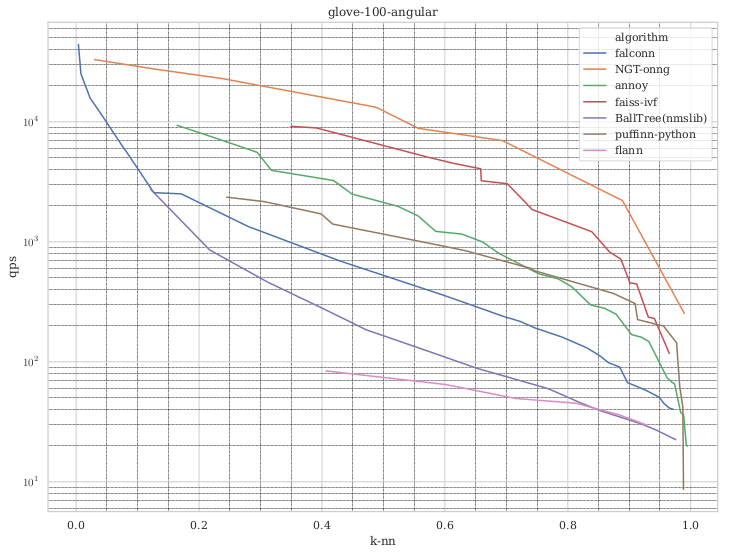

In [707]:
plot_comparison()

\begin{tikzpicture}[every mark/.append style={mark size=1.5pt}]
            \begin{axis}[
                title = {Comparison on gnews-300-angular-middle},
                xlabel = {},
                ylabel = {},
                width = \textwidth,
                height = 6cm,
                ymode=log,
                legend style = {opacity = 0.6, text opacity = 1},
                grid = both, grid style={line width=.1pt, draw=gray!30},
major grid style={line width=.2pt,draw=gray!50},
            ]
            
\addplot coordinates { (0.537270, 2660.996829) (0.579510, 1968.293189) (0.801900, 1258.983180) (0.857190, 917.348178) (0.877180, 808.319733) (0.897130, 474.684879) (0.914210, 243.798380) (0.971820, 154.996579) (0.977760, 106.226679) (0.982770, 90.499913) (0.986560, 50.067590) (0.987320, 29.255316) (0.990020, 29.207692) (0.992680, 15.272680) };
\addlegendentry{faiss-ivf};
\addplot coordinates { (0.179920, 16049.137250) (0.253440, 13091.592357) (0.371220, 10971.096598) (0.761

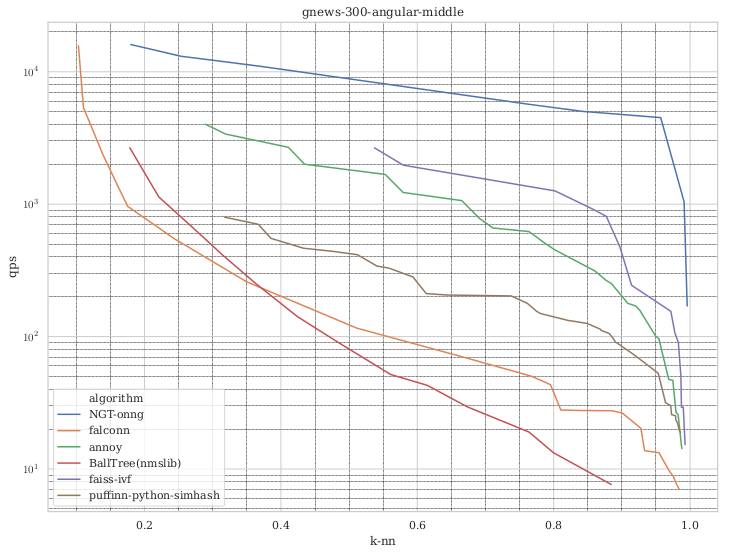

In [711]:
plot_comparison('gnews-300-angular-middle', algorithms=['BallTree(nmslib)', 'falconn', 'puffinn-python-simhash', 'annoy', 'faiss-ivf', 'flann', 'NGT-onng'])

\begin{tikzpicture}[every mark/.append style={mark size=1.5pt}]
            \begin{axis}[
                title = {Comparison on glove-2m-300-angular-middle},
                xlabel = {},
                ylabel = {},
                width = \textwidth,
                height = 6cm,
                ymode=log,
                legend style = {opacity = 0.6, text opacity = 1},
                grid = both, grid style={line width=.1pt, draw=gray!30},
major grid style={line width=.2pt,draw=gray!50},
            ]
            
\addplot coordinates { (0.565030, 2960.373800) (0.592570, 2020.101597) (0.618340, 1420.979473) (0.752390, 1296.812646) (0.774020, 1290.796422) (0.815010, 1031.502691) (0.832520, 796.742088) (0.840090, 563.384564) (0.900410, 348.324086) (0.907250, 201.895021) (0.922970, 193.349818) (0.941090, 115.758326) (0.949190, 64.096256) (0.959570, 38.001092) (0.967400, 18.436840) (0.969450, 13.133526) (0.984930, 9.613749) (0.996570, 4.936213) (0.998850, 4.443679) };
\addlegendentry{

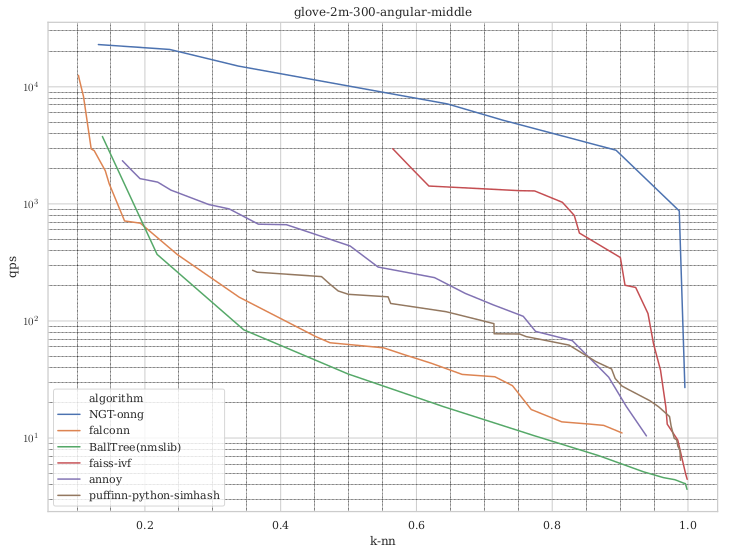

In [712]:
plot_comparison('glove-2m-300-angular-middle', algorithms=['BallTree(nmslib)', 'falconn', 'puffinn-python-simhash', 'annoy', 'faiss-ivf', 'flann', 'NGT-onng'])

\begin{tikzpicture}[every mark/.append style={mark size=1.5pt}]
            \begin{axis}[
                title = {Comparison on difficult-annoy-angular},
                xlabel = {},
                ylabel = {},
                width = \textwidth,
                height = 6cm,
                ymode=log,
                legend style = {opacity = 0.6, text opacity = 1},
                grid = both, grid style={line width=.1pt, draw=gray!30},
major grid style={line width=.2pt,draw=gray!50},
            ]
            
\addplot coordinates { (0.001000, 4665.236314) (0.002000, 3390.229805) (0.003000, 2077.375346) (0.004000, 1504.388433) (0.005000, 1337.468555) (0.013000, 705.752269) (0.033000, 446.253319) (0.050000, 278.018691) (0.086000, 145.871374) (0.116000, 80.488105) (0.220000, 41.135089) };
\addlegendentry{faiss-ivf};
\addplot coordinates { (0.605000, 748.519862) (0.820000, 514.856424) (0.971000, 360.306134) (0.978000, 243.791433) (0.992000, 178.238772) (0.995000, 156.441904) (0.99900

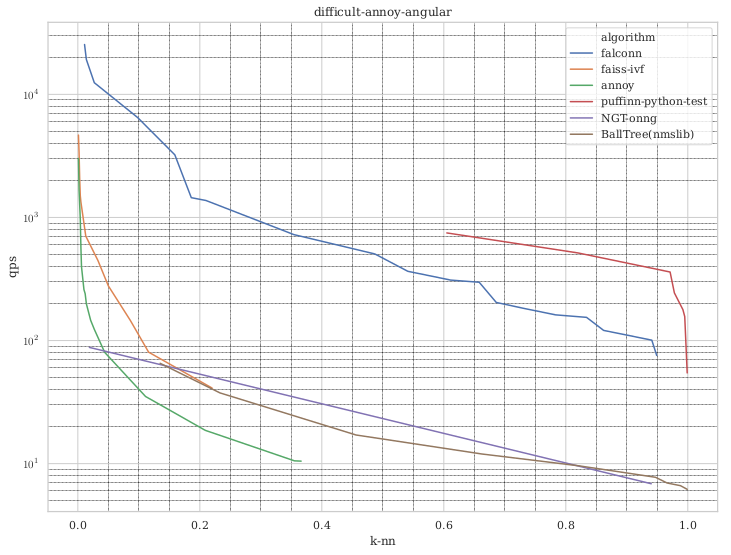

In [704]:
plot_comparison('difficult-annoy-angular', algorithms=['BallTree(nmslib)', 'falconn', 'flann', 'faiss-ivf', 'annoy', 'NGT-onng', 'puffinn-python-test'], count=1)

In [666]:
data[(data.dataset == 'difficult-annoy-angular') & (data['count'] == 1)]

,algorithm,build,candidates,count,dataset,distcomps,epsilon,indexsize,k-nn,k-nn-median,k-nn-perc-25,k-nn-perc-5,k-nn-perc-75,k-nn-perc-95,k-nn-std,largeepsilon,parameters,qps,qps-median,qps-perc-25,qps-perc-5,qps-perc-75,qps-perc-95,queriessize,rel
0,hnsw(faiss),229.697639,1.0,1,difficult-annoy-angular,6.097434e+03,0.000,1321080.0,0.000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,"faiss ({u'efConstruction': 500, u'M': 8})",347.496180,355.479614,346.150360,336.885184,357.784180,359.964294,3801.710860,1.743438
1,hnsw(faiss),7804.277806,1.0,1,difficult-annoy-angular,1.335257e+05,0.000,2022492.0,0.000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,"faiss ({u'efConstruction': 500, u'M': 96})",19.497806,19.534058,19.435079,19.280876,19.590214,19.644090,103729.210553,1.688313
2,hnsw(faiss),747.532169,1.0,1,difficult-annoy-angular,1.862304e+04,0.000,1445332.0,0.000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,"faiss ({u'efConstruction': 500, u'M': 24})",150.524667,151.091644,150.625015,143.841528,151.533798,152.255500,9601.961099,1.711060
3,hnsw(faiss),7804.277806,1.0,1,difficult-annoy-angular,3.700780e+04,0.000,2022492.0,0.000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,"faiss ({u'efConstruction': 500, u'M': 96})",73.551996,73.841431,73.561050,71.770934,74.046745,74.289573,27497.445536,1.696033
4,hnsw(faiss),7804.277806,1.0,1,difficult-annoy-angular,7.832219e+03,0.000,2022492.0,0.000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,"faiss ({u'efConstruction': 500, u'M': 96})",341.028051,352.225739,348.682678,317.311658,354.727997,358.181396,5930.573728,1.723421
5,hnsw(faiss),3289.922612,1.0,1,difficult-annoy-angular,9.272623e+04,0.000,1759620.0,0.000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,"faiss ({u'efConstruction': 500, u'M': 64})",28.141591,28.216730,27.992118,27.809059,28.300549,28.373673,62527.382660,1.689879
6,hnsw(faiss),1209.979083,1.0,1,difficult-annoy-angular,2.781375e+04,0.000,1540412.0,0.000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,"faiss ({u'efConstruction': 500, u'M': 36})",86.236974,86.618011,86.132416,83.869562,86.919571,87.228774,17862.546981,1.702686
7,hnsw(faiss),373.049630,1.0,1,difficult-annoy-angular,4.689704e+03,0.000,1350716.0,0.000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,"faiss ({u'efConstruction': 500, u'M': 12})",517.445740,521.096313,518.135132,502.790565,523.045776,526.327515,2610.352922,1.747859
8,hnsw(faiss),3289.922612,1.0,1,difficult-annoy-angular,5.270916e+03,0.000,1759620.0,0.000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,"faiss ({u'efConstruction': 500, u'M': 64})",508.830594,511.095367,506.512581,497.238246,515.207458,520.259268,3458.164705,1.732966
9,hnsw(faiss),2528.560589,1.0,1,difficult-annoy-angular,1.883315e+04,0.000,1634584.0,0.000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,"faiss ({u'efConstruction': 500, u'M': 48})",160.266241,162.230377,160.361839,152.186715,163.183441,164.014268,10199.178512,1.706583


## Influence of Index size

In [519]:
df = data[data.parameters.str.contains('filter')].reset_index()

splitting = df['parameters'].str.split(" ", expand=True)

df['space'] = splitting[0]
df['recall'] = splitting[1]
df['sketch_eps'] = splitting[2]
df['filter'] = splitting[3]

index_size_df = df[df['filter'].str.contains('=simple') & ~df['space'].str.contains('00000')][['space','qps','k-nn']]

\begin{tikzpicture}[every mark/.append style={mark size=1.5pt}]
            \begin{axis}[
                title = {Influence of Index size},
                xlabel = {},
                ylabel = {},
                width = \textwidth,
                height = 6cm,
                ymode=log,
                legend style = {opacity = 0.6, text opacity = 1},
                grid = both, grid style={line width=.1pt, draw=gray!30},
major grid style={line width=.2pt,draw=gray!50},
            ]
            
\addplot coordinates { (0.367200, 2515.122205) (0.470590, 1671.278202) (0.661030, 762.693220) (0.776500, 474.166746) (0.891390, 219.366445) (0.922510, 151.620309) (0.967630, 74.147491) };
\addlegendentry{PUFFINN(space=2294967296,};
\addplot coordinates { (0.455340, 1851.714399) (0.496530, 1483.303657) (0.711220, 671.488070) (0.805140, 457.223737) (0.901290, 305.465230) (0.943720, 211.285127) (0.971990, 122.818919) };
\addlegendentry{PUFFINN(space=4294967296,};
\addplot coordinates { (0.32

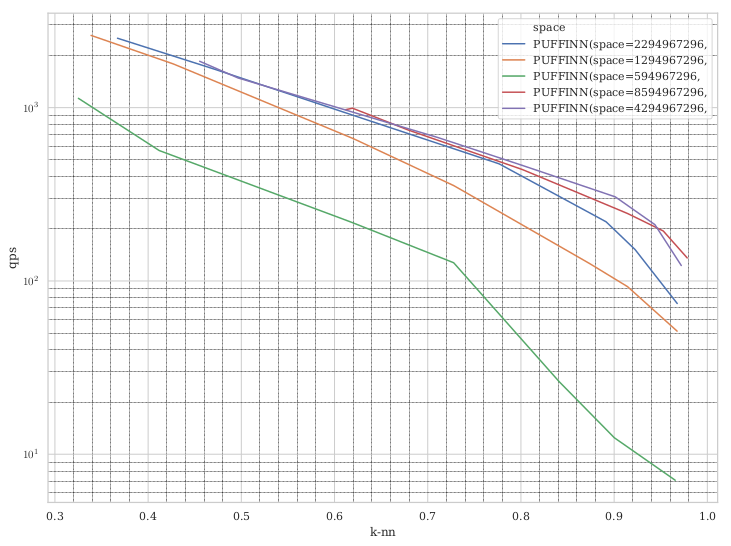

In [516]:
ax = sns.lineplot(x='k-nn', y='qps', hue='space', data=index_size_df)
ax.set_yscale('log')
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')

pgfplot(index_size_df, 'k-nn', 'qps', 'space', 'Influence of Index size')

Almost no improvement over 2gb index (only for very large recall). Let's try the same for no filter index.

\begin{tikzpicture}[every mark/.append style={mark size=1.5pt}]
            \begin{axis}[
                title = {Influence of Index size / no sketching},
                xlabel = {},
                ylabel = {},
                width = \textwidth,
                height = 6cm,
                ymode=log,
                legend style = {opacity = 0.6, text opacity = 1},
                grid = both, grid style={line width=.1pt, draw=gray!30},
major grid style={line width=.2pt,draw=gray!50},
            ]
            
\addplot coordinates { (0.409270, 1473.337212) (0.516860, 747.175312) (0.730590, 276.325748) (0.850290, 150.298829) (0.950620, 51.652549) (0.970160, 30.782238) (0.992040, 12.602538) };
\addlegendentry{PUFFINN(space=2294967296,};
\addplot coordinates { (0.530490, 898.193404) (0.567850, 805.809243) (0.775120, 299.487249) (0.866350, 182.199221) (0.945830, 100.939947) (0.974600, 59.115333) (0.989220, 26.795525) };
\addlegendentry{PUFFINN(space=4294967296,};
\addplot coordinates

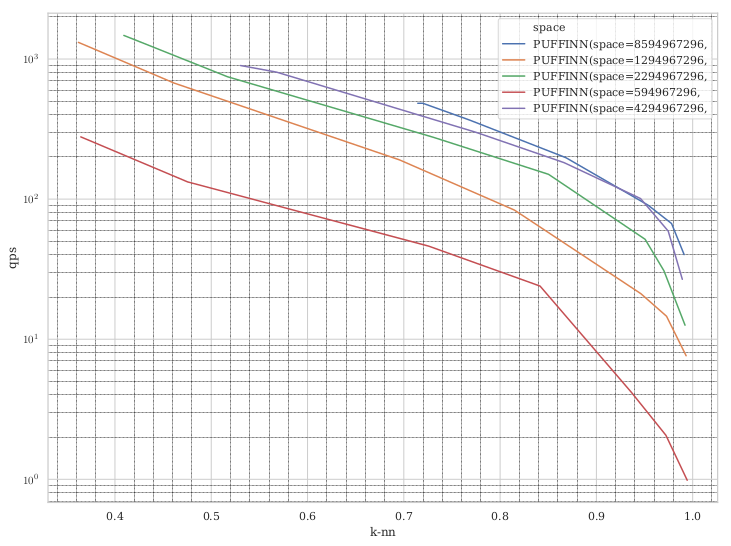

In [520]:
index_size_df_no_filter = df[df['filter'].str.contains('=none') & ~df['space'].str.contains('00000')][['space','qps','k-nn']]
ax = sns.lineplot(x='k-nn', y='qps', hue='space', data=index_size_df_no_filter)
ax.set_yscale('log')
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
pgfplot(index_size_df_no_filter, 'k-nn', 'qps', 'space', 'Influence of Index size / no sketching')

Without sketches, we have "the more the better".